# Thresholding

# Introduction

In this lab we will learn how to apply thresholding methods to remotely sensed imagery and classify water and land.

A threshold is a value which seperates a distribution into two distinct classes. A threshold is defined based on the distribution of the backscatter coefficients. It is most easily decided when the distribution is bimodel, causing two distinct groups of pixels to emerge.

A threshold may be determined manually, by assessing the distribution of the backscatter coefficients.

The threshold may also be determined by an iterative algorithm.

Thresholding is a common approach for water extent mapping as it can be used to create a binary classification of water and land.



In [31]:
# Import the libraries we are going to need
import ee
import numpy as np
import geemap.foliumap as geemap
import pandas as pd
import plotnine
from plotnine import *
import pprint

# Set up a 'pretty printer' to print ...
pp = pprint.PrettyPrinter(depth=3)

# Follow the link to authenticate and initialize this instance of GEE in CoLab
ee.Authenticate()
ee.Initialize(project='ee-cptcitrus-main')

# Manual Thresholding

We will start with manual thresholding by classifying the area over the Bay of Fundy into water and land with a Sentinel-1 image.

Manual thresholding involves the analysis of the bands of an image to determine if there is an optimal way to divide the pixels into two classes.

If there is a bimodal distribution in the pixel values of a band, meaning there are two distinct groups of values, there is likely a case for thresholding with that data.

In [2]:
# Define our area of interest as a point
# Bay of Fundy, Canada
aoi = ee.Geometry.Point(-66.298957, 44.85135)

# Filter the Sentinel-1 GRD (Ground Range Detection) image collection to get a single image to work with
s1_image = ee.ImageCollection('COPERNICUS/S1_GRD') \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
                .filterBounds(aoi) \
                .filterDate('2018-04-01','2018-05-31') \
                .first()

## Generate Training Data
Next we are going to create random samples throughout our image and extract the data at those locations. We'll use the resulting data to assess the distribution of the pixels in the image. This is called training data.

In [3]:
# First we will get the image bounds
# We will restrict our samples to be within this polygon
imggeom = s1_image.geometry()

# Then we will use randomPoints() to create our random sample points
randomSamples = ee.FeatureCollection.randomPoints(imggeom, 500, seed = 42)


In [4]:
# Lets visualize our random sample points on a map
# Create the map object
Map = geemap.Map()

# Set the visualization parameters
S1_vis = {
  'bands': ['VV'],
  'min': -20,
  'max': 0,
  'gamma': 1.4,
}

# Add the layers to the map
Map.addLayer(imggeom)
Map.addLayer(s1_image, S1_vis, "S1_VV")
Map.addLayer(randomSamples, {}, 'random points')

# Add layer control and center the map on the image
Map.addLayerControl()
Map.centerObject(s1_image, 7)

Map

In [5]:
# We'll create a 'bands' variable which contains a list of strings, 'VV' and 'VH'
bands = ['VV', 'VH']

# For each training data point we will extract the pixel value
# We will use sampleRegions below and it requires a "label" so here we are setting a property named "label" and giving all points a value of 1
randomSamples= randomSamples.set('label', 1)

# We'll define a variable which we will fill with our training data
# We are selecting VV and VH from the image for each sample location
extracted = s1_image.select(bands).sampleRegions(
  collection = randomSamples,
  properties = None,
  scale = 30
)

In this lab we will use the package "pandas" which allows us to store data in a tabular format and perform statitical analysis using its functions.

We make use of it here to display our data values. If we tried to view our extracted feature as is using the .getInfo() function it would be in json format which is quite difficult to interpret.

When we convert the feature to a pandas dataframe we move from GEE servers to the "client side" and start working on Google CoLab's servers instead.

In [6]:
# To examine our training data, we will convert our ee features to a pandas data frame
df = geemap.ee_to_df(extracted)

# The head function just displays the first few records of our training data
print("The first few records are as follows:")
df.head()

The first few records are as follows:


,VH,VV
0,-33.959433,-8.968913
1,-28.488592,-7.740094
2,-15.236582,-10.891541
3,-26.661972,-9.468921
4,-24.904098,-9.047721


You can see that for each point we now have a value extracted from the image for VV and VH.

## Examine the Histograms

Next we'll create a histogram to display the VH training data using ggplot.

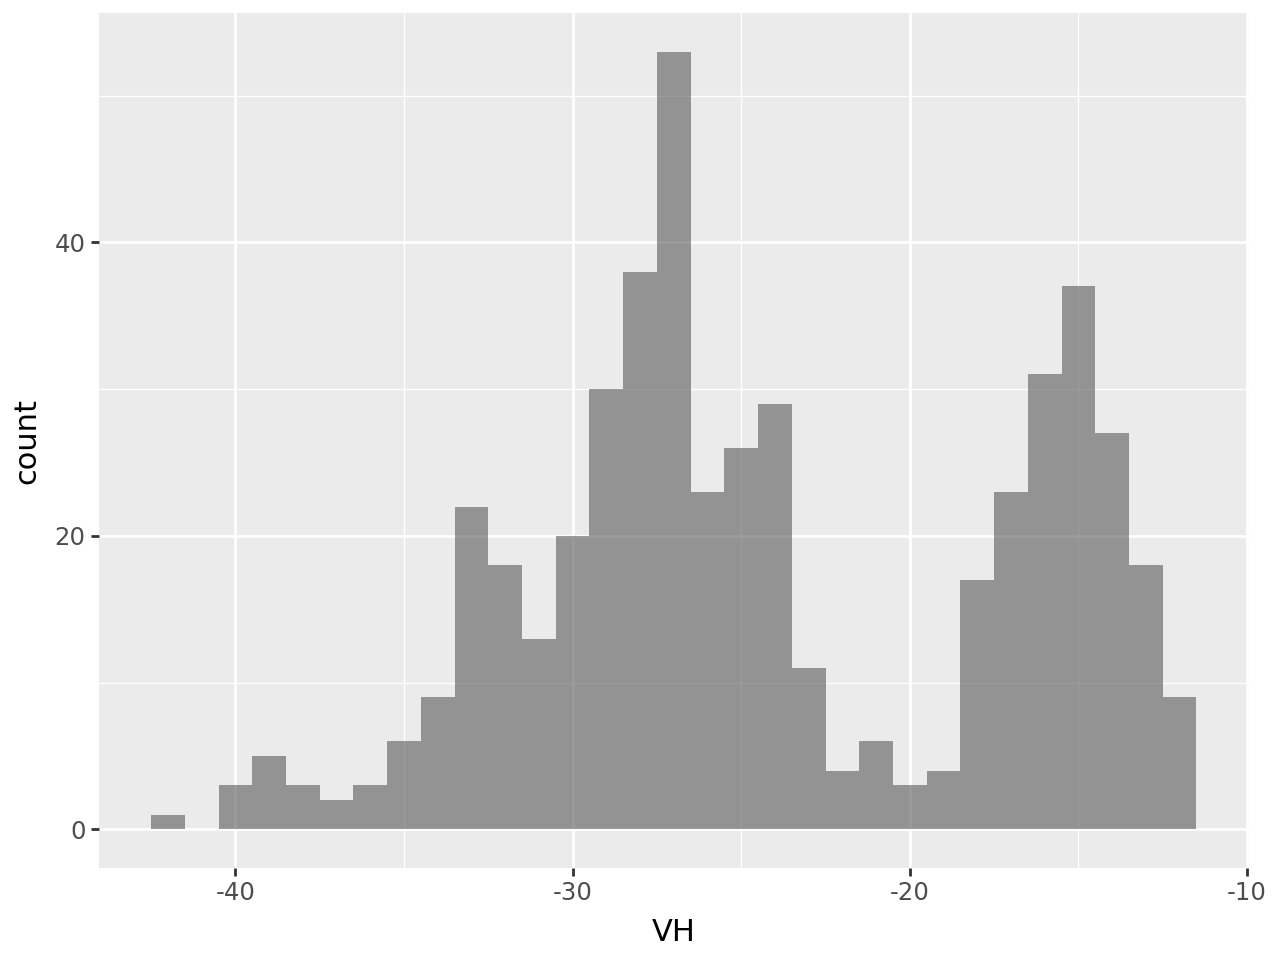

In [7]:
# Use the ggplot() function
  # Provide the input datafame first
  # aes(x = 'VH') indicates the column from the dataframe which will be used as the x axis variable
# Concatenate (+) that with the geom_histogram function to specify the type of plot
  # There are other plot types that work with ggplot
  # alpha provides the level of transparency of the bars of the histogram
  # binwidth controls the aggregation of bins that the histogram generated
    # we picked binwidth=1 so we aren't aggregating any bins together
(
ggplot(df, aes(x = "VH"))
+ geom_histogram(alpha=0.6, binwidth = 1)
)

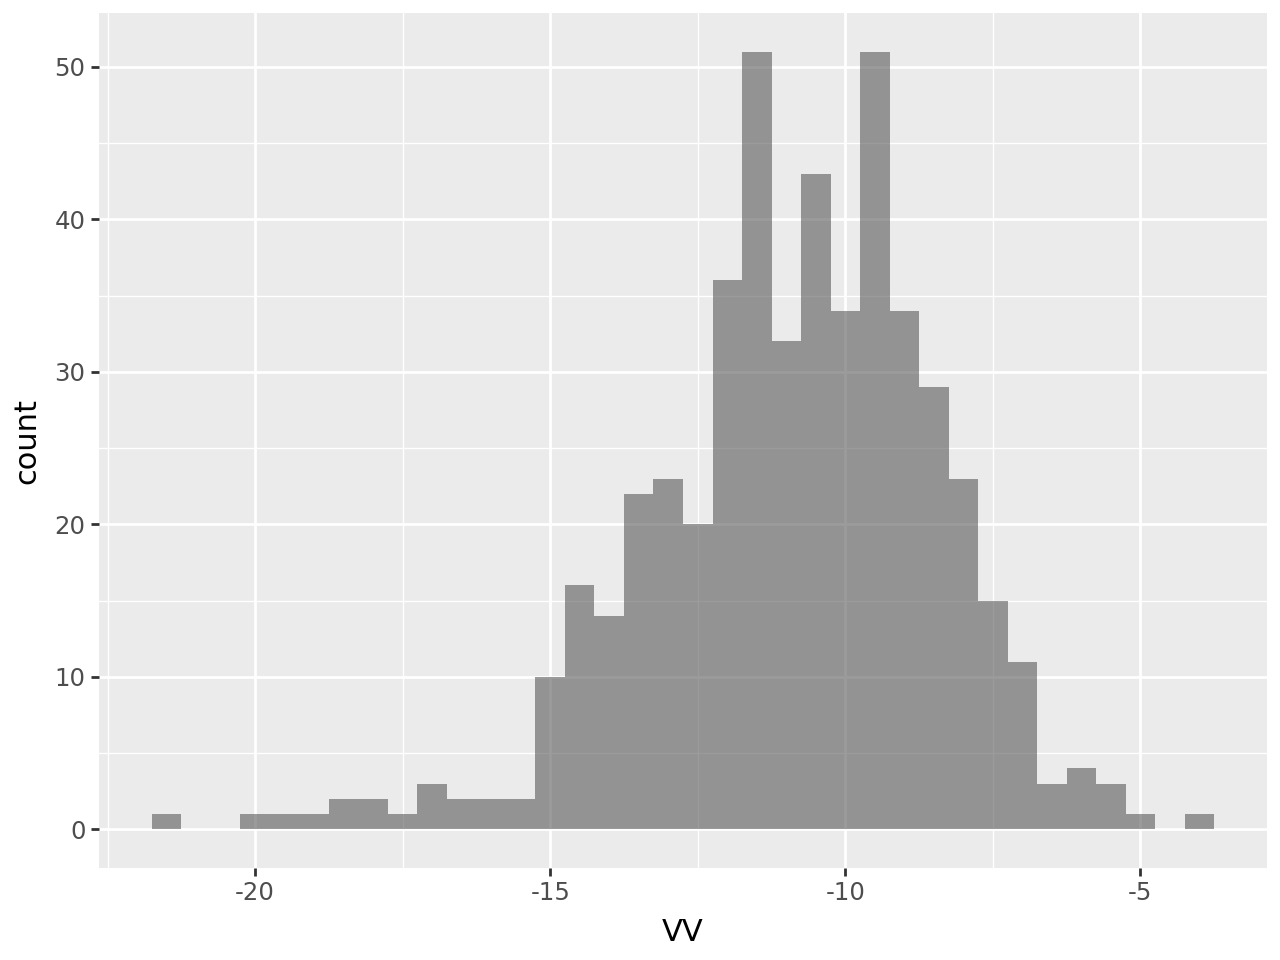

In [8]:
# Create a histogram to display our VV training data using the same method with ggplot
(
ggplot(df, aes(x = "VV"))
+ geom_histogram(alpha=0.6, binwidth = 0.5)
)

## Manual Placement

In examining our histograms we see that the VH training data is definitely bimodal, assuming this is representative of our image, we can easily see where we could place a threshold. The modes are different sizes but we could place a threshold around -20.

The VV training data does not have a bimodal distribution. Is a threshold appropriate for unimodal distribution?

We'll do the best we can to estimate the middle of the distribution visually. It looks close to -12.

In [9]:
# Let's put the VH threshold in the middle of the two modes, about -20
manual_thresholdVH = s1_image.select('VH').lte(-20).rename('threshVH')

# Here I put the threshold right in the middle of the distribution
manual_thresholdVV = s1_image.select('VV').lte(-12).rename('threshVV')

## Classification Results

Now we'll use our determined thresholds and plot the VV and VH images on a map.

We need to create visualization parameters. We will display water using the VV threshold in blue and the water for VH threshold in red.

In [10]:
Map = geemap.Map(width = 1000, height = 1000)

thresholdVV_vis = {
  'bands': ['threshVV'],
  'min': 0,
  'max': 1,
  'palette': ['FFFFFF', '00FFFF'] #blue
}

thresholdVH_vis = {
  'bands': ['threshVH'],
  'min': 0,
  'max': 1,
  'palette': ['FFFFFF', 'FF0000'] #red
}

# We're creating two visualization parameters for the S1 image so that we can see VV and VH
# This will help us see why the classification results turned out the way they did
# Visualizing the VV band
S1_vis_VV = {
  'bands': ['VV'],
  'min': -20,
  'max': 0,
  'gamma': 1.4,
}

# Visualizing the VH band
S1_vis_VH = {
  'bands': ['VH'],
  'min': -20,
  'max': 0,
  'gamma': 1.4,
}

# Add the s1 image twice, once with each visualization parameter we made
Map.addLayer(s1_image,  S1_vis_VV,'S1-image_VV')
Map.addLayer(s1_image,  S1_vis_VH,'S1-image_VH')

# Add the classified images
Map.addLayer(manual_thresholdVV,  thresholdVV_vis, 'VV threshold')
Map.addLayer(manual_thresholdVH,  thresholdVH_vis, 'VH threshold')

Map.centerObject(aoi,8)
Map.addLayerControl()

Map

Take a look at our classified images and compare them with the corresponding S1 image bands.

The VH thresholding did an excellent job- the entirety of the Bay is classified as water with no confusion. If we look at S1_image_VH we can see why the classification worked so well. The water is very clearly seperate from land in the VH band. This explains why we had a bimodal distribution in the historgram we examined.

The VV thresholding did not classify this area as well. You can see there is some confusion between rough water and land. We can tell this is the case because the misclassified areas follow the pattern of waves that we can see in the S1_image_VV. The land and the water have areas that are the same pixel value (same colour on the greyscale we are displaying). This explains why the histogram distribution was unimodal.

This is a good example of the rule that image bands which have a bimodal distribution are best suited to thresholding methods because there is a definitive point of seperation where the threshold can be placed.


# Otsu Thresholding

Next we will explore Otsu thresholding for the same AOI. We can compare whether the manual thresholding method or this iteratire method produces a better classification.

The Otsu method of determining a threshold was defined by Nobuyuki Otsu in 1979. It is an iterative method which aims to determine the optimal threshold by placing it such that the class seperation maximizes between-class (interclass) variance. The iterative part is that the algorithm walks through all probable threshold values and computes the class probabilities and means for each.

## Set up Otsu Functions

We first need to set up two functions to run the Otsu algorithm. The first will return the DN (Digital Number) that maximizes interclass variance for the region. We're setting the functions up to run Otsu on both bands (VV and VH).

In [11]:
# The original version of this function found here: https://zenodo.org/record/4910772#.YNt6HehKiUk

def otsu(histogram):
    """
    Function to use Otsu algorithm to compute DN that maximizes interclass variance in the region
    args: Histogram
    returns: Otsu's threshold
    """
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)
    indices = ee.List.sequence(1, size)

    # Compute between sum of squares, where each mean partitions the data
    def func_bss(i):
        aCounts = counts.slice(0, 0, i)
        aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
        aMeans = means.slice(0, 0, i)
        aMean = aMeans.multiply(aCounts) \
            .reduce(ee.Reducer.sum(), [0]).get([0]) \
            .divide(aCount)
        bCount = total.subtract(aCount)
        bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
        return aCount.multiply(aMean.subtract(mean).pow(2)).add(
               bCount.multiply(bMean.subtract(mean).pow(2)))

    bss = indices.map(func_bss)
    return means.sort(bss).get([-1])


Next we will define a function that extracts water from our image, and also returns the value of our thresholds.

In [22]:
def add_S1_waterMask(img):
    """
    Function to extract surface water from Sentinel-1 images Otsu algorithm
    args: Image
    returns: Image with water mask
    """
    # Compute histogram
    reducers = ee.Reducer.histogram(255,2).combine(reducer2=ee.Reducer.mean(), sharedInputs=True)\
        .combine(reducer2=ee.Reducer.variance(), sharedInputs= True)

    histogramVV = img.select('VV').reduceRegion(
    reducer=reducers,
    geometry=aoi,
    scale=10,
    bestEffort=True)

    histogramVH = img.select('VH').reduceRegion(
    reducer=reducers,
    geometry=aoi,
    scale=10,
    bestEffort=True)

    # We will calculate the threshold values using the otsu function we created (see before)
    thresholdVV = otsu(histogramVV.get('VV_histogram'))
    thresholdVH = otsu(histogramVH.get('VH_histogram'))

    # Get watermask for VV
    waterMaskVV = img.select('VV').lt(thresholdVV).rename('waterMaskVV')
    waterMaskVV = waterMaskVV.updateMask(waterMaskVV) #Remove all pixels equal to 0

    # Get watermask for VH
    waterMaskVH = img.select('VH').lt(thresholdVH).rename('waterMaskVH')
    waterMaskVH = waterMaskVH.updateMask(waterMaskVH) #Remove all pixels equal to 0

    return img.addBands(waterMaskVV).addBands(waterMaskVH).set('date', img.date().format()).set('thresholdVV',thresholdVV).set('thresholdVH',thresholdVH)

## Get Images and Apply Functions

Now we will filter an image collection by our AOI and other parameters to get a Sentinel-1 image stack within our selected date range.

In [23]:
# Bay of Fundy (still)
aoi = ee.Geometry.Point(-66.298957, 44.85135)

s1_stack_asc =  ee.ImageCollection('COPERNICUS/S1_GRD') \
  .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
  .filter(ee.Filter.eq('instrumentMode', 'IW')) \
  .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
  .filterBounds(aoi) \
  .filterDate('2018-04-01','2018-05-31')

Then we will call our functions on our image stack so we can see what the thresholds actually are.

(Calling the second function we defined (add_S1_waterMask() will call the otsu() function through it.)

In [24]:
otsuThreshold_setImages = s1_stack_asc.map(add_S1_waterMask)

# We'll extract the list of thresholds from the data and look at them
nested_list = otsuThreshold_setImages.reduceColumns(ee.Reducer.toList(3), ['date','thresholdVV', 'thresholdVH']).values().get(0)
df = pd.DataFrame(nested_list.getInfo(), columns=['date','thresholdVV', 'thresholdVH'])
df

,date,thresholdVV,thresholdVH
0,2018-04-05T22:18:52,-10.745644,-22.540000
1,2018-04-17T22:18:53,-16.182041,-45.619857
2,2018-04-29T22:18:54,-14.632071,-33.374432
3,2018-05-11T22:18:54,-17.176178,-28.350043
4,2018-05-23T22:18:55,-18.364798,-30.069775


## Classification Results

We will apply the threshold as a mask which will map the water bodies.

In [25]:
otsu_s1 = s1_stack_asc.map(add_S1_waterMask)

Map = geemap.Map(width = 1000, height = 1000)

waterMaskVV_vis = {
  'bands': ['waterMaskVV'],
  'min': 0,
  'max': 1,
  'palette': ['FFFFFF','00FFFF'] #blue
}

waterMaskVH_vis = {
  'bands': ['waterMaskVH'],
  'min': 0,
  'max': 1,
  'palette': ['FFFFFF', 'FF0000'] #red
}

S1_vis_VV = {
  'bands': ['VV'],
  'min': -20,
  'max': 0,
  'gamma': 1.4,
}

S1_vis_VH = {
  'bands': ['VH'],
  'min': -20,
  'max': 0,
  'gamma': 1.4,
}

Map.addLayer(s1_stack_asc.first(),  S1_vis_VV,'S1-image VV', shown = False)
Map.addLayer(s1_stack_asc.first(),  S1_vis_VH,'S1-image VH')
Map.addLayer(otsu_s1.select('waterMaskVV').first(),  waterMaskVV_vis, 'VV watermask', shown = False)
Map.addLayer(otsu_s1.select('waterMaskVH').first(),  waterMaskVH_vis, 'VH watermask')

Map.centerObject(aoi, 8)
Map.addLayerControl()

Map

# Comparing the Results

Our results should be roughly the same as, if not better than our manual thresholding results. Are they?

Our VH classification is almost perfect, just like with manual thresholding. We know that this is because the obviously bimodal distribution of the data makes it easy to pick a threshold. The Otsu algorithm would very easily be able to find the perfect value for a threshold to maximize interclass variance.

Our VV classification is better than it was with our manually selected threshold. Remember that the distribution for VV was unimodal so we had to put an approximate threshold at the mean. Otsu is better at determining the best threshold using it's iterative methods than we are at estimating based on the mean of the data. Now a lot more of the water is correctly classified as water, even though there is still some confusion between rough water and land.


# Questions to Submit

Answer the following questions below. Feel free to add additional code and text cells as needed. Show all of your code.

If you use code from another source, please ensure you reference where you found it.

## Q1 (1 point)

Run the following code blocks and look at the histograms for our training data.

**Based on visually examining histograms, where do you think the thresholds should be placed for VV and VH ? Briefly explain why you chose those values.**

(You do not need to do any calculations to answer this question.)

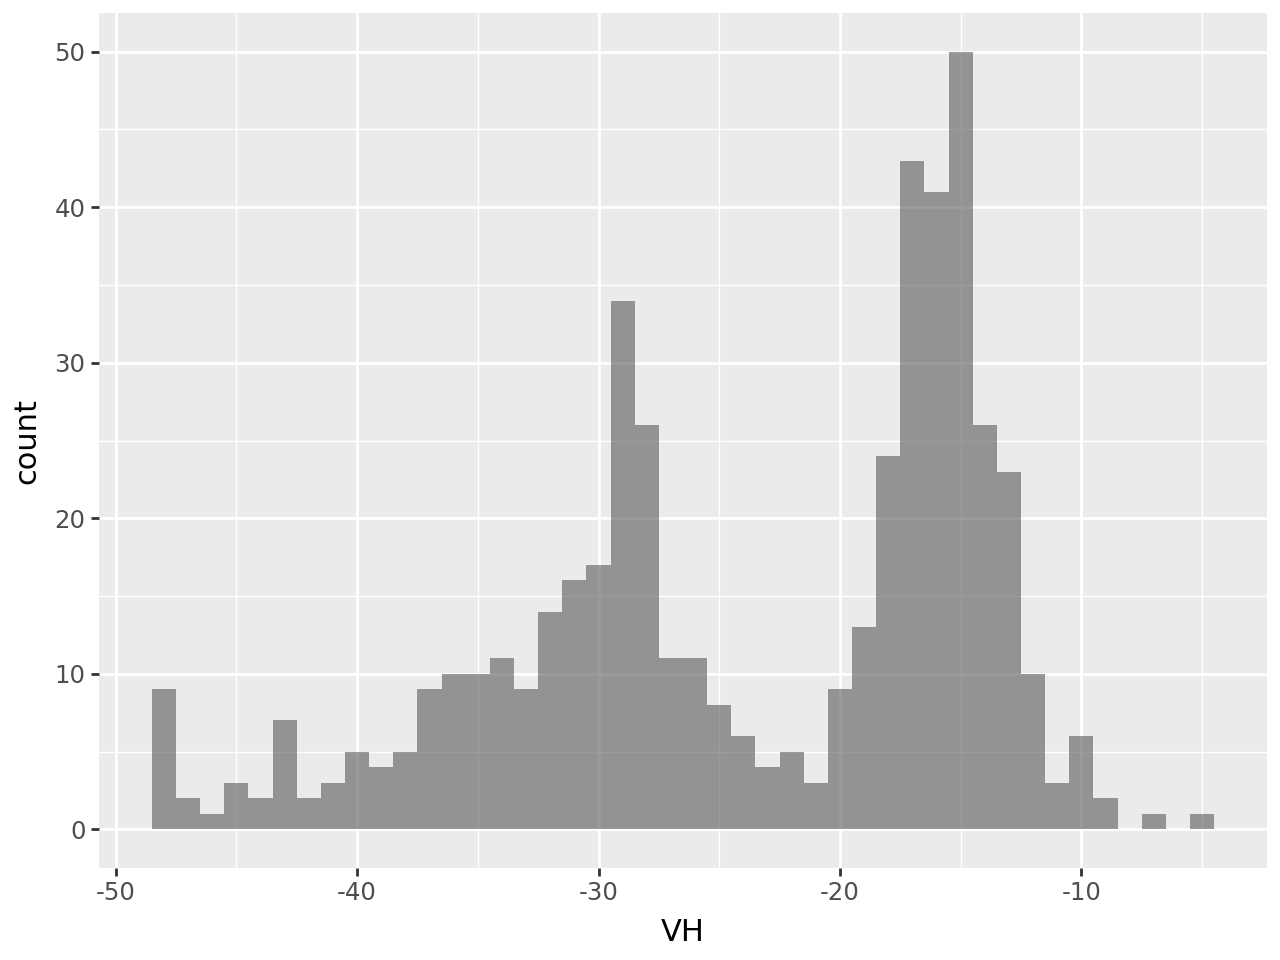

In [26]:
# Define our area of interest (St. Lawrence)
aoi = ee.Geometry.Point(-66.2805, 49.6605)

# Filter the Sentinel-1 GRD collection for an image
s1_image = ee.ImageCollection('COPERNICUS/S1_GRD') \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
                .filterBounds(aoi) \
                .filterDate('2019-05-01','2019-09-30') \
                .first()

imggeom = s1_image.geometry()
randomSamples = ee.FeatureCollection.randomPoints(imggeom, 500, seed = 42)
bands = ['VV', 'VH']

# Extract the pixel value
randomSamples= randomSamples.set('label', 1) #we will use sampleRegions below and it requires a "label" so here we are setting a property named "label" and giving all points a value of 1

# Fill a variable with our extracted training data
extracted = s1_image.select(bands).sampleRegions(
  collection = randomSamples,
  properties = None,
  scale = 30
)

# Convert our ee features to a pandas data frame
df = geemap.ee_to_df(extracted)

# Produce the VH histogram
(
ggplot(df, aes(x = "VH"))
+ geom_histogram(alpha=0.6, binwidth = 1)
)

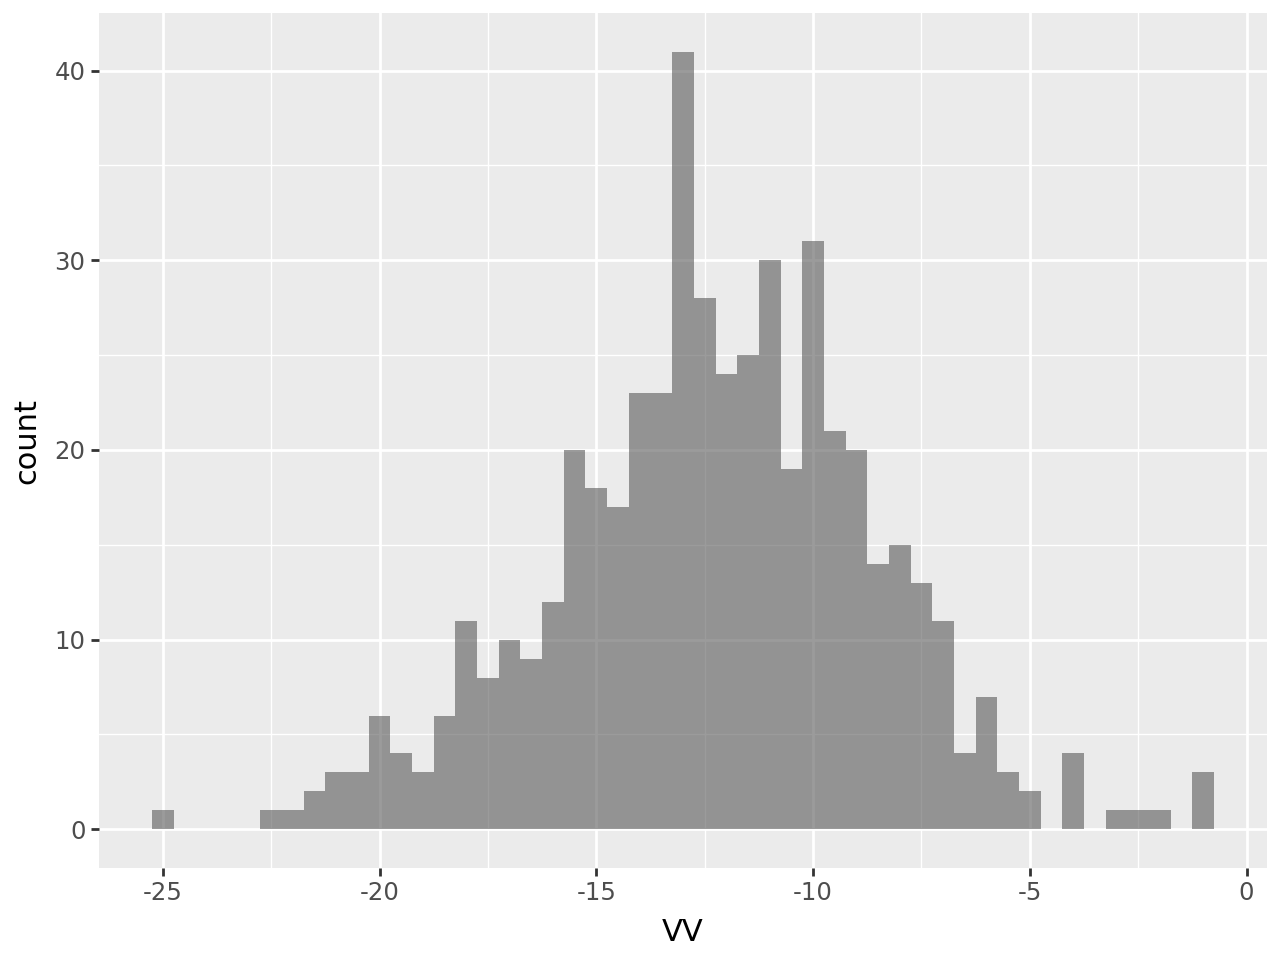

In [27]:
# Produce the VV histogram
(
ggplot(df, aes(x = "VV"))
+ geom_histogram(alpha=0.6, binwidth = 0.5)
)


// Write your answer here
The VH histogram has a clear breakpoint at approximately -21.

The VV histogram is more difficult to interpret, because no clear breakpoint exists, but an approximate breakpoint might be -12. It would be easiest to use an algorithm for determining the best breakpoint, such as Otsu, but alternately a k-means clustering algorithm may show that more than 1 division is appropriate.

## Q2 (2 points)
Use Otsu thresholding to produce one VV and one VH classified image.

Your AOI (coordintes in the code block below) is over the middle of Ungava Bay, Nunavut.

**Adjust the imageCollection filtering below to reflect an image stack for April and May of 2017.**

**Display the results on a map. Give a brief summary of the results.**

(Remember that we've already defined the functions in the code above so we don't need to re-do that here.)

In [32]:
#Set up functions
# The original version of this function found here: https://zenodo.org/record/4910772#.YNt6HehKiUk

def otsu(histogram):
    """
    Function to use Otsu algorithm to compute DN that maximizes interclass variance in the region
    args: Histogram
    returns: Otsu's threshold
    """
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)
    indices = ee.List.sequence(1, size)

    # Compute between sum of squares, where each mean partitions the data
    def func_bss(i):
        aCounts = counts.slice(0, 0, i)
        aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
        aMeans = means.slice(0, 0, i)
        aMean = aMeans.multiply(aCounts) \
            .reduce(ee.Reducer.sum(), [0]).get([0]) \
            .divide(aCount)
        bCount = total.subtract(aCount)
        bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
        return aCount.multiply(aMean.subtract(mean).pow(2)).add(
               bCount.multiply(bMean.subtract(mean).pow(2)))

    bss = indices.map(func_bss)
    return means.sort(bss).get([-1])

def add_S1_waterMask(img):
    """
    Function to extract surface water from Sentinel-1 images Otsu algorithm
    args: Image
    returns: Image with water mask
    """
    # Compute histogram
    reducers = ee.Reducer.histogram(255,2).combine(reducer2=ee.Reducer.mean(), sharedInputs=True)\
        .combine(reducer2=ee.Reducer.variance(), sharedInputs= True)

    histogramVV = img.select('VV').reduceRegion(
    reducer=reducers,
    geometry=aoi,
    scale=10,
    bestEffort=True)

    histogramVH = img.select('VH').reduceRegion(
    reducer=reducers,
    geometry=aoi,
    scale=10,
    bestEffort=True)

    # We will calculate the threshold values using the otsu function we created (see before)
    thresholdVV = otsu(histogramVV.get('VV_histogram'))
    thresholdVH = otsu(histogramVH.get('VH_histogram'))

    # Get watermask for VV
    waterMaskVV = img.select('VV').lt(thresholdVV).rename('waterMaskVV')
    waterMaskVV = waterMaskVV.updateMask(waterMaskVV) #Remove all pixels equal to 0

    # Get watermask for VH
    waterMaskVH = img.select('VH').lt(thresholdVH).rename('waterMaskVH')
    waterMaskVH = waterMaskVH.updateMask(waterMaskVH) #Remove all pixels equal to 0

    return img.addBands(waterMaskVV).addBands(waterMaskVH).set('date', img.date().format()).set('thresholdVV',thresholdVV).set('thresholdVH',thresholdVH)

In [37]:
## Show your code here
## AOI is Ungava Bay, NT
aoi = ee.Geometry.Point(-67.270540,59.529817)
start_date = "2017-04-01"
end_date = "2017-05-31"

s1_image_stack = ee.ImageCollection('COPERNICUS/S1_GRD') \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                .filterDate(start_date, end_date)\
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
                .filterBounds(aoi)

otsuThreshold_setImages = s1_image_stack.map(add_S1_waterMask)


# We'll extract the list of thresholds from the data and look at them
nested_list = otsuThreshold_setImages.reduceColumns(ee.Reducer.toList(3), ['date','thresholdVV', 'thresholdVH']).values().get(0)
pp.pprint(nested_list)

df = pd.DataFrame(nested_list.getInfo(), columns=['date','thresholdVV', 'thresholdVH'])
pp.pprint(df)
df

                  date  thresholdVV  thresholdVH
0  2017-04-18T22:06:04   -13.196693   -22.408679
1  2017-04-30T22:06:05   -14.050403   -24.377955
2  2017-05-12T22:06:05   -13.476008   -19.155053
3  2017-05-24T22:06:06   -12.503229   -21.297282


,date,thresholdVV,thresholdVH
0,2017-04-18T22:06:04,-13.196693,-22.408679
1,2017-04-30T22:06:05,-14.050403,-24.377955
2,2017-05-12T22:06:05,-13.476008,-19.155053
3,2017-05-24T22:06:06,-12.503229,-21.297282


In [38]:
#otsu_s1 = s1_image_stack.map(add_S1_waterMask)

Map = geemap.Map(width = 1000, height = 1000)

waterMaskVV_vis = {
  'bands': ['waterMaskVV'],
  'min': 0,
  'max': 1,
  'alpha': 0.6,
  'palette': ['FFFFFF','00FFFF'] #blue
}

waterMaskVH_vis = {
  'bands': ['waterMaskVH'],
  'min': 0,
  'max': 1,
  'alpha': 0.6,
  'palette': ['FFFFFF', 'FF0000'] #red
}

S1_vis_VV = {
  'bands': ['VV'],
  'min': -15,
  'max': 0,
  'gamma': 1.4,
}

S1_vis_VH = {
  'bands': ['VH'],
  'min': -25,
  'max': 0,
  'gamma': 1.4,
}

Map.addLayer(otsuThreshold_setImages.first(),  S1_vis_VV,'S1-image VV', shown = False)
Map.addLayer(otsuThreshold_setImages.first(),  S1_vis_VH,'S1-image VH')
Map.addLayer(otsuThreshold_setImages.select('waterMaskVV').first(),  waterMaskVV_vis, 'VV watermask', shown = False)
Map.addLayer(otsuThreshold_setImages.select('waterMaskVH').first(),  waterMaskVH_vis, 'VH watermask')

Map.centerObject(aoi, 8)
Map.addLayerControl()

Map

// Write your answer here

Both VV and VH thresholded images do a good job of identifying the land but include a lot of ice. VH includes more ice as "water" than VV, which is more discrimatory and calls ice "water" less often. However, they are both including a ton of ice as "land".

## Q3 (1 point)

Run the following code block and examine the classified outputs. Are these an example of a well-placed threshold? What is wrong with the classification?

In [39]:
# Define our area of interest
# Strait of Georgian Bay, ON
aoi = ee.Geometry.Point(-80.8456,45.2826)

# Filter the Sentinel-1 GRD collection for an image
s1_image = ee.ImageCollection('COPERNICUS/S1_GRD') \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
                .filterBounds(aoi) \
                .filterDate('2019-05-01','2019-06-30') \
                .first()

imggeom = s1_image.geometry()
randomSamples = ee.FeatureCollection.randomPoints(imggeom, 500, seed = 42)
bands = ['VV', 'VH']

# Extract the pixel value
randomSamples= randomSamples.set('label', 1) #we will use sampleRegions below and it requires a "label" so here we are setting a property named "label" and giving all points a value of 1

# Fill a variable with our extracted training data
extracted = s1_image.select(bands).sampleRegions(
  collection = randomSamples,
  properties = None,
  scale = 30
)

manual_thresholdVV = s1_image.select('VV').lte(-25).rename('threshVV')
manual_thresholdVH = s1_image.select('VH').lte(-30).rename('threshVH')


Map = geemap.Map(width = 1000, height = 1000)

thresholdVV_vis = {
  'bands': ['threshVV'],
  'min': 0,
  'max': 1,
  'palette': ['FFFFFF', '00FFFF'] #blue
}

thresholdVH_vis = {
  'bands': ['threshVH'],
  'min': 0,
  'max': 1,
  'palette': ['FFFFFF', 'FF0000'] #red
}

S1_vis_VV = {
  'bands': ['VV'],
  'min': -20,
  'max': 0,
  'gamma': 1.4,
}

S1_vis_VH = {
  'bands': ['VH'],
  'min': -20,
  'max': 0,
  'gamma': 1.4,
}

#Map.addLayer(s1_stack_asc.first(),  S1_vis,'S1-image')
Map.addLayer(s1_image,  S1_vis_VV,'S1-imageVV')
Map.addLayer(s1_image,  S1_vis_VH,'S1-imageVH')
Map.addLayer(manual_thresholdVV,  thresholdVV_vis, 'VV threshold')
Map.addLayer(manual_thresholdVH,  thresholdVH_vis, 'VH threshold')

Map.centerObject(s1_image,7)
Map.addLayerControl()

Map


// Write your answer here
These are inappropriate thresholds, probably set too low, because we are getting a very high rate of false negatives (assuming the goal was to detect water). Testing with a histogram:

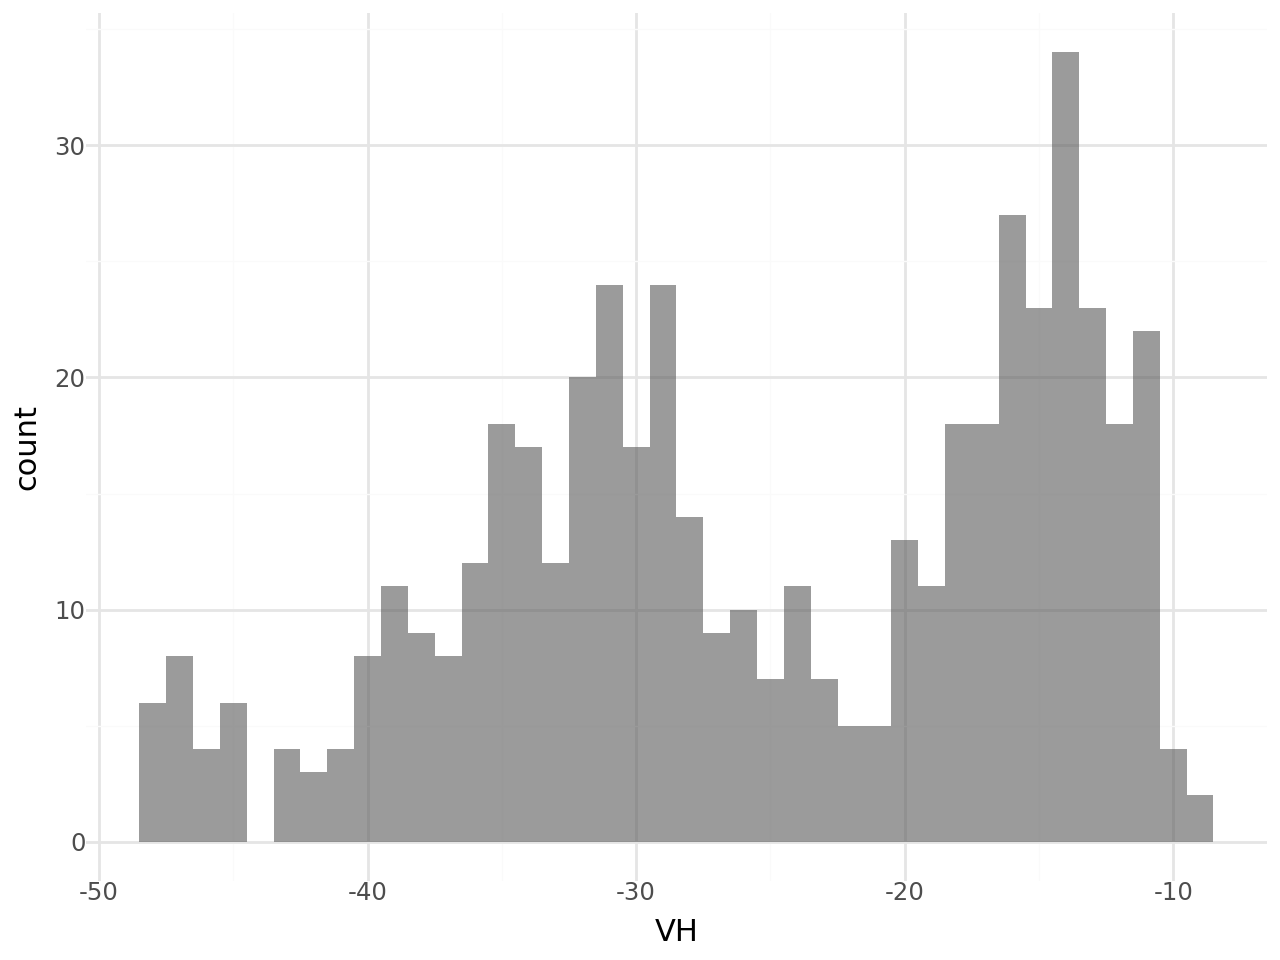

In [40]:
df = geemap.ee_to_df(extracted)

(
ggplot(df, aes(x = "VH", fill = "VH"))
+ geom_histogram(alpha=0.6, binwidth = 1)
+ theme_minimal()
)

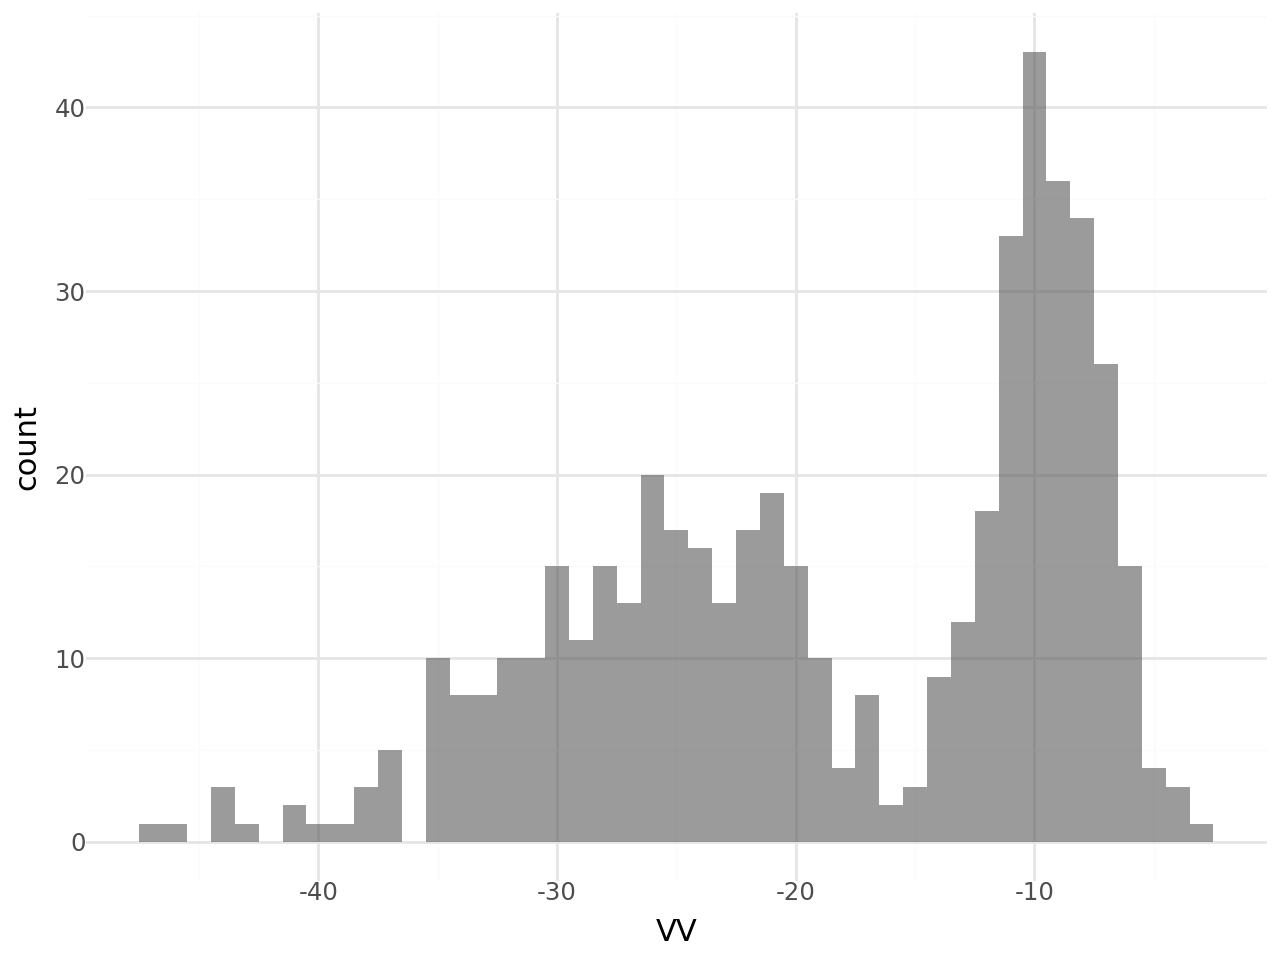

In [41]:
(
ggplot(df, aes(x = "VV", fill = "VV"))
+ geom_histogram(alpha=0.6, binwidth = 1)
+ theme_minimal()
)

In [42]:
manual_thresholdVV = s1_image.select('VV').lte(-16).rename('threshVV')
manual_thresholdVH = s1_image.select('VH').lte(-22).rename('threshVH')


Map = geemap.Map(width = 1000, height = 1000)

#Map.addLayer(s1_stack_asc.first(),  S1_vis,'S1-image')
Map.addLayer(s1_image,  S1_vis_VV,'S1-imageVV')
Map.addLayer(s1_image,  S1_vis_VH,'S1-imageVH')
Map.addLayer(manual_thresholdVV,  thresholdVV_vis, 'VV threshold')
Map.addLayer(manual_thresholdVH,  thresholdVH_vis, 'VH threshold')

Map.centerObject(s1_image,7)
Map.addLayerControl()

Map

In [ ]:
This works much better